In [19]:
import cortex
import numpy as np
import matplotlib.pyplot as plt

In [20]:
%matplotlib inline

In [21]:
cortex.database.default_filestore

'/lab_data/tarrlab/common/datasets/pycortex_db_NSD'

In [22]:
print(cortex.options.usercfg)
from cortex.options import config
print(config.get('webgl', 'colormaps'))

/home/yuanw3/.config/pycortex/options.cfg
/home/yuanw3/.local/share/pycortex/colormaps/


In [23]:
from scipy.sparse import csr_matrix

In [24]:
# surface = 'sub-09-stroke'
surface = "subj01"
# xfm = 'sub-09_ses-01_task-Fullfield_run-01MRIDeSkulledOptimizedFeatures'
xfm = "func1pt8_to_anat0pt8_autoFSbbr"

# mask = cortex.db.get_mask(surface,xfm,'cortical')
mask=cortex.utils.get_cortical_mask(surface, xfm)

In [25]:
print(mask.shape)

(83, 104, 81)


In [26]:
print(np.sum(mask>0))
print(mask.sum())

74497
74497


In [27]:
mask_with_idx = np.zeros(mask.shape)
mask_with_idx[mask==False] = np.nan
mask_with_idx[mask==True] = np.arange(mask.sum())

In [28]:
mask_with_idx.shape

(83, 104, 81)

In [29]:
# mapper = cortex.get_mapper(surface, xfm, 'nearest', recache=True)
mapper = cortex.get_mapper(surface, xfm, 'trilinear', layers=32, recache=True)

Caching mapper...


In [12]:
tmp = np.zeros(mask.shape)
tmp[mask_with_idx==1] = 1
voxel_vol = cortex.Volume(tmp,surface,xfm)

In [13]:
print(tmp.shape)
print(np.sum(tmp))

(83, 104, 81)
1.0


In [14]:
nc = mapper(voxel_vol).data.shape[0]
nc1 = int(np.floor(nc/2)) # for efficiency
nc2 = nc-nc1

all_idx_1 = np.zeros((mask.sum(),nc1), dtype=bool) # (#voxel x nc1) 
all_idx_2 = np.zeros((mask.sum(),nc2), dtype=bool) # (#voxel x nc2) 

In [15]:
print(np.sum(mapper(voxel_vol).data))
print(len(mapper(voxel_vol).data))

1.26588963282849
453622


In [16]:
print(nc)
print(nc1)
print(nc1)
print(mask.sum())
print(len(all_idx_1))
print(len(all_idx_1[0]))
print(len(all_idx_2))
print(len(all_idx_2[0]))

453622
226811
226811
74497
74497
226811
74497
226811


In [17]:
###########################
#test with a sample voxel #
###########################
j = 10001
tmp[mask_with_idx==j] = 1 # set that voxel to be true in the volume 
voxel_vol = cortex.Volume(tmp,surface,xfm) # make a volume object out of it
tmp = mapper(voxel_vol).data > 0 # make a "binary" array where vertexes are on for that voxel 
print(tmp.shape)
print(np.nonzero(tmp))
all_idx_1[j] = tmp[:nc1] # boolean 
all_idx_2[j] = tmp[nc1:]

(453622,)
(array([344408, 344409, 344423, 345900, 345901, 345915, 345916, 345917,
       345927, 347306, 347324, 347325, 347341, 348814, 348815, 383695,
       383696, 385004, 385005, 385006, 386312, 386315, 386316, 386317,
       387676, 387679, 387680]),)


In [ ]:
# # list of non-zero arguments
# for j in np.arange(mask.sum()): # for each voxel j
#     tmp = np.zeros(mask.shape) # temporary 3d volume
#     tmp[mask_with_idx==j] = 1 # set that voxel to be true in the volume 
#     voxel_vol = cortex.Volume(tmp,surface,xfm) # make a volume object out of it
#     tmp = mapper(voxel_vol).data > 0 # make a "binary" array where vertexes are on for that voxel 
#     all_idx_1[j] = tmp[:nc1] # boolean 
#     all_idx_2[j] = tmp[nc1:]
#     if j%1000==0:
#         print(j)
        

# list of non-zero arguments
for j in np.arange(mask.sum()): # for each voxel j
    tmp = np.zeros(mask.shape) # temporary 3d volume
    tmp[mask_with_idx==j] = 10 # set that voxel to be true in the volume 
    voxel_vol = cortex.Volume(tmp,surface,xfm) # make a volume object out of it
    tmp = mapper(voxel_vol).data > 0 # make a "binary" array where vertexes are on for that voxel 
    tmp = tmp.astype(bool)
    all_idx_1[j,tmp[:nc1]==True] = 1 # boolean 
    all_idx_2[j,tmp[nc1:]==True] = 1 
    if j%1000==0:
        print(j, tmp.sum())

In [ ]:
all_vox = np.zeros((mask.sum(),mask.sum()))

In [ ]:
###########################
#test with a sample voxel #
###########################
j = 10001
non_zero_1 = all_idx_1[j]>0 # boolean array of non zero vertexs for that voxel
sub_mat_1 = all_idx_1[:,non_zero_1].sum(1) # an array of voxel that are adjacent to those vertexes
all_vox[j,sub_mat_1>0] = 1
non_zero_2 = all_idx_2[j]>0
sub_mat_2 = all_idx_2[:,non_zero_2].sum(1)
all_vox[j,sub_mat_2>0] = 1

print(np.sum(all_vox))

In [ ]:
all_vox = np.zeros((mask.sum(),mask.sum())) # initiate a voxel adjacency matrix

for j in np.arange(mask.sum()): # for each voxel
    non_zero_1 = all_idx_1[j]>0 # boolean array of non zero vertexs for that voxel
    sub_mat_1 = all_idx_1[:,non_zero_1].sum(1) # an array of voxel that are adjacent to those indexes
    all_vox[j,sub_mat_1>0] = 1 # set the adjacent voxels to positive in the matrix
    non_zero_2 = all_idx_2[j]>0 # repeat the same process for the second half
    sub_mat_2 = all_idx_2[:,non_zero_2].sum(1)
    all_vox[j,sub_mat_2>0] = 1
    if j%1000==0:
        print(j)

In [ ]:
max_n_neighbors = int(np.max(all_vox.sum(1)))+1 # max number of neighbors any voxel has
print(max_n_neighbors)

all_vox_neighbors = np.zeros((mask.sum(),max_n_neighbors))-1 # initiate a array of -1 to store neighbors

for j in np.arange(mask.sum()): # for each voxel
    tmp = np.where(all_vox[j]>0)[0] # find the indexs of its neighboring voxels
    tmp = np.concatenate([tmp,np.array([j])]) # concatenate the indexes with itself
    all_vox_neighbors[j,0:len(tmp)] = tmp # store it in the array

In [47]:
max_2nd_neighbors = 200

all_vox_2nd_neighbors = np.zeros((mask.sum(),max_2nd_neighbors))-1

for j in np.arange(mask.sum()):    
    tmp2 = all_vox_neighbors[j] # indexes of all neighbors of voxel j
    tmp2 = tmp2[tmp2>=0].astype(int) 
    tmp = np.unique(all_vox_neighbors[tmp2])
    tmp = tmp[tmp>=0]
    all_vox_2nd_neighbors[j,:len(tmp)] = tmp



In [30]:
# np.save('/user_data/yuanw3/project_outputs/NSD/output/searchlight/vox_neighborhood_subj1.npy',all_vox_neighbors)
all_vox_neighbors = np.load('/user_data/yuanw3/project_outputs/NSD/output/searchlight/vox_neighborhood_subj1.npy')

In [48]:
np.save('/user_data/yuanw3/project_outputs/NSD/output/searchlight/vox_2nd_neighbors_subj1.npy', all_vox_2nd_neighbors)
# all_vox_2nd_neighbors = np.load('/user_data/yuanw3/project_outputs/NSD/output/searchlight/vox_2nd_neighbors_subj1.npy')

In [36]:
all_vox_neighbors.shape

(74497, 27)

In [37]:
all_vox_neighbors[1,:]

array([ 0.0000e+00,  1.0000e+00,  9.0000e+00,  1.0000e+01,  1.1000e+01,
        1.6000e+01,  1.7000e+01,  1.8000e+01,  2.3000e+01,  2.4000e+01,
        2.5000e+01,  1.0001e+04,  1.0000e+00, -1.0000e+00, -1.0000e+00,
       -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
       -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
       -1.0000e+00, -1.0000e+00])

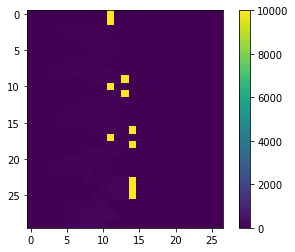

In [38]:
plt.imshow(all_vox_neighbors[:30,:])
plt.colorbar()

In [39]:
all_vox_2nd_neighbors.shape

(74497, 80)

In [50]:
vols = dict()

data = np.zeros((30,mask.sum())) # voxels to be visualized

for i in range(30):
    voxels = all_vox_2nd_neighbors[20000+i]
#     voxels = np.where(all_vox[i+25000]>0)[0]
    voxels = voxels[voxels>=0]
    voxels = np.unique(voxels).astype(int)
#     print("Num of neighbors: " + str(len(voxels)))
    data[i][voxels] = 1
    data[i][20000+i] = 2
    vols['{}'.format(i)] = cortex.Volume(data[i], surface, xfm, mask=mask, vmin=0,vmax=2)
    
cortex.webgl.show(vols, cmap="Blues", port=24124)
# cortex.quickshow(vols['0'])

Started server on port 24124


<JS: window.viewer>

In [ ]:
subject = 'subj01'

# In order to get the number of vertices in this subject's cortical surface
# we have to load in their surfaces and get the number of points in each
surfs = [cortex.polyutils.Surface(*d)
         for d in cortex.db.get_surf(subject, "fiducial")]

# This is the total number of vertices in both hemispheres combined
num_verts = surfs[0].pts.shape[0] + surfs[1].pts.shape[0]

# Creating a random dataset with one entry for each vertex
test_data = np.arange(num_verts)/num_verts

# This creates a Vertex object for our subject and test dataset
vertex_data = cortex.Vertex(test_data, subject)
# And now we can display it on a flatmap
# cortex.quickshow(vertex_data)
cortex.webshow(vertex_data)

In [ ]:
subject = "subj01"

# First we need to import the surfaces for this subject
surfs = [cortex.polyutils.Surface(*d)
         for d in cortex.db.get_surf(subject, "fiducial")]

# Then we will pick one vertex in each hemisphere to find distances to
vert = 10000
dists = [s.geodesic_distance(vert) for s in surfs]

# Now we can plot these distances onto a flatmap
all_dists = np.hstack((dists[0], dists[1]))
dist_map = cortex.Vertex(all_dists, subject, cmap="hot")
cortex.quickshow(dist_map,with_rois=False)
# plt.show()

# Alternatively, you can find the minimum distance from a set of points to the
# surface
# Here, we use an example of an ROI
all_eba = cortex.utils.get_roi_verts(subject, "EBA")["EBA"]

# We have to then separate these vertices by hemisphere
numl = surfs[0].pts.shape[0]
eba_verts = [all_eba[all_eba < numl], all_eba[all_eba >= numl] - numl]

# Now look at geodesic distances for each hemisphere separately
dists = [s.geodesic_distance(verts) for s, verts in zip(surfs, eba_verts)]
all_dists = np.hstack((dists[0], dists[1]))

# And now plot these distances onto the cortical surface
dist_map = cortex.Vertex(all_dists, subject, cmap="hot")
cortex.quickshow(dist_map,with_rois=False);
# plt.show()